# NMR Scalar Coupling (J-Coupling)
---

## Table of Contents
- [Introduction](#id-section1)
- [Python Code](#id-section2)
  * [Predicting Mulliken Charges Using ACSFs](#id-section21)
      * [The cutoff function](#id-section211)
      * [Two-body Radial ACSF: $G^1_i$](#id-section212)
      * [The radial symmetry ACSF: $G_i^2$](#id-section213)
      * [The Mulliken charges](#id-section214)
  * [Predicting J-Couplings](#id-section22)
      * [Load data](#id-section221)
      * [Merge charges to our dataset](#id-section222)
      * [Data Statistics](#id-section223)
      * [Define Model 1: Random Forest Regressor](#id-section224)
      * [Results of model 1](#id-section225)
      * [Training with Subsets of dataset](#id-section226)
      * [Define model 2: Deep Neural Network](#id-section227)
      * [Results of model 2](#id-section228)
      * [Training with Subset of dataset](#id-section229)
  * [Summary](#id-section23)

<div id='id-section1'/>

## Introduction

A **J-coupling** is an interaction between nuclei containing spin. J-couplings are also known as scalar couplings. This interaction is mediated through bonds, in contrast to dipole interactions, which are mediated through space. Typically, we consider the J-coupling to be a weak interaction, in comparison to the Zeeman interaction. It is an indirect interaction between two nuclear spins that arises from hyperfine interactions between the nuclei and local electrons.


J-couplings are typically used in combination with chemical shifts to deduce the through-bond connectivity in small molecules and proteins. While typically a liquid state phenomena, solid-state J-coupling constants are observable. J-coupling values range in 0.1 Hz in organic compounds to kHz in transition metal complexes. The J-coupling typically reduces in magnitude the more bonds exist between the coupled nuclei. Furthermore, J-couplings may be either homonuclear (i.e. between hydrogens with different chemical shifts) or heteronuclear (i.e. between hydrogen and carbon).

In **NMR spectroscopy**, J-coupling contains information about *relative bond distances* and *angles*. Most importantly, J-coupling provides information on the connectivity of chemical bonds. It is responsible for the often complex splitting of resonance lines in the NMR spectra of fairly simple molecules. J-coupling is a frequency difference that is not affected by the strength of the magnetic field, so is always stated in Hz.

In this project, we will develop an algorithm that can predict the magnetic interaction between two atoms in a molecule (i.e., the scalar coupling constant). There are several input features that are available:

* Dipole moments
* Magnetic Shielding Tensors
* Mulliken Charges
* Potential Energy
* Scalar Coupling Contributions
* XYZ Coordinates of the Molecules

Train and Test datasets are already available. Here we use Mulliken charges and the type of interaction in order to predict J-couplings. Note that since we do not have Mulliken charges for the molecules in the test dataset we need to predict those charges first. We use a method which was originally introduced by Boris D. (https://www.kaggle.com/borisdee).

<div id='id-section2'/>

## Python Code


<div id='id-section21'/>

## 1. Predicting Mulliken charges using Atom-Centered Symmetry Functions (ACSFs)

Atom-centered Symmetry Functions (**ACSFs**) can be used to represent the local environment near an atom by using a fingerprint composed of the output of multiple two- and three-body functions that can be customized to detect specific structural features. These are local descriptors that are very powerful because they contain a lot of information on the chemical environment around each atom. They are based on a function called the **cutoff function**.


<div id='id-section211'/>

### 1.1. The cutoff function 
The cutoff function can be written as follows:

$$
f_c(R_{ij}) = 
\left\{
    \begin{array}{ll}
    0.5 \left[ \cos\left( \pi\frac{R_{ij}}{R_c} \right) + 1 \right] & {\rm for} \quad R_{ij} \leq R_c \\
    0  & {\rm for} \quad R_{ij} > R_c \\
    \end{array}
\right.
$$

where $R_{ij}$ is the distance between atoms $i$ and $j$, and if this distance is greater than a **cutoff radius** $R_c$, then the cutoff function becomes zero. Let's plot this function for a several different values of $R_c$ to better understand the behavior of the cutoff function.

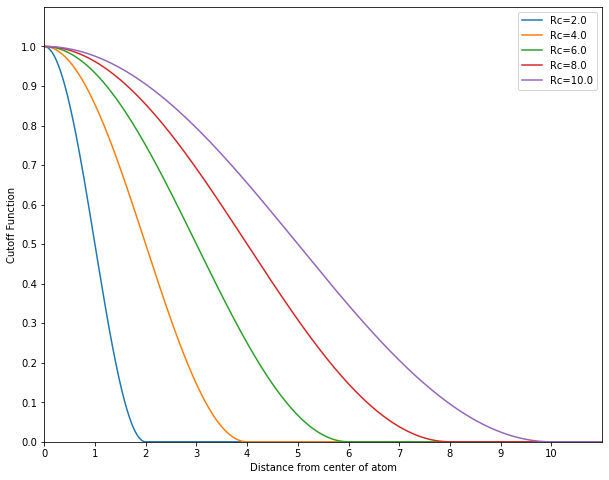

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# The cutoff function
def cutoff_fc(Rij, Rc):
    return np.concatenate((0.5*(np.cos(np.pi*Rij[Rij<=Rc]/Rc)+1),Rij[Rij>Rc]*0))


# Define grid
x = np.arange(0, 11, 0.01)

# Plot the function with different cutoff radii
Rc_range = [2.0, 4.0, 6.0, 8.0, 10.0]

fig = plt.figure(figsize=(10,8))

for Rc in Rc_range:
    plt.plot(x, cutoff_fc(x,Rc), label=f'Rc={Rc}')

plt.axis([0, 11, 0, 1.1])
plt.xticks(range(11))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('Distance from center of atom')
plt.ylabel('Cutoff Function')
plt.legend()
    
plt.show()

All **ACSFs** are built on top of this function, acting as a **weight function**. The closer we are to the atom center the more important the weight would be.

<div id='id-section212'/>

### 1.2. Two-body Radial ACSF: $G^1_i$
$G^1_i$ is the most basic radial function that describes the environment of an atom $i$. It's called a **two-body** ACSF because it involves pairs of atoms. It's just the sum of the plain cutoff functions with respect to each neighboring atom $j$:
$$ G_i^1 = \sum\limits_{j=1}^{N_{\rm atom}} f_c(R_{ij})$$

**The physical interpretation of $G^1_i$ is the coordination number of atom $i$ within the cutoff radius.**

As an example, let's consider a simple molecule: ethanol C$_2$H$_5$OH.

In [2]:
import ase.visualize
from ase.build import molecule

# Create the methanol molecule
ethanol = molecule('CH3CH2OH')

To find the ideal cutoff radius $R_c$, let's check what is the maximum distance between two atoms:

In [3]:
max(ethanol.get_all_distances().flatten())

4.069405205410368

We can therefore use $R_c=4.1$ and we'll be sure to include all the atoms in the neighborhood of each atom.

In [4]:
Rc = 4.1

Now let's calculate $G^1_C$ for the carbon atom. First let's identify which one is the carbon atom:

In [5]:
ethanol.get_chemical_symbols()

['C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H']

Now we get the distances between this atom and every other atoms. To do that, we use the `get_all_distances()` method, which returns the distances of all of the atoms with every other atom:

In [6]:
all_dist = ethanol.get_all_distances()
print('This is the distance matrix:')
print(all_dist)

dist_from_C = all_dist[0]
print('')
print('Distances from carbon atom to every other atoms:\n', dist_from_C)

This is the distance matrix:
[[0.         1.51193497 2.36458006 3.21144555 2.15383142 2.15383142
  1.09333328 1.09175654 1.09175654]
 [1.51193497 0.         1.42684013 1.95473852 1.0992838  1.0992838
  2.15613991 2.1466157  2.1466157 ]
 [2.36458006 1.42684013 0.         0.97132389 2.08944599 2.08944599
  3.32689003 2.61083643 2.61083643]
 [3.21144555 1.95473852 0.97132389 0.         2.32932075 2.32932075
  4.06940521 3.50066459 3.50066459]
 [2.15383142 1.0992838  2.08944599 2.32932075 0.         1.773866
  2.49293247 2.49366296 3.05961163]
 [2.15383142 1.0992838  2.08944599 2.32932075 1.773866   0.
  2.49293247 3.05961163 2.49366296]
 [1.09333328 2.15613991 3.32689003 4.06940521 2.49293247 2.49293247
  0.         1.7767203  1.7767203 ]
 [1.09175654 2.1466157  2.61083643 3.50066459 2.49366296 3.05961163
  1.7767203  0.         1.771762  ]
 [1.09175654 2.1466157  2.61083643 3.50066459 3.05961163 2.49366296
  1.7767203  1.771762   0.        ]]

Distances from carbon atom to every other at

Now let's calculate $G^1_C$:

In [7]:
G1_C = cutoff_fc(dist_from_C, Rc).sum()
print('G1 for the carbon atom:', G1_C)

G1 for the carbon atom: 5.617592384347159


Let's calculate the $G^1$ array, which contains the $G^1$ of all atoms in the molecule:

In [8]:
# Number of atoms in the molecules
natom = len(ethanol.get_chemical_symbols())

# Definition of a vectorized cutoff function
def fc_vect(Rij, Rc):
    return np.where(Rij <= Rc, 0.5 * (np.cos(np.pi * Rij/Rc)+1), 0).sum(1)

# Calculate G1
G1 = fc_vect(all_dist, Rc)

print(G1)

[5.61759238 6.01774618 4.61655301 3.40708512 4.59428672 4.59428672
 4.25423485 4.33516823 4.33516823]


The result is one number for each atom in the molecule, with larger values indicating more atoms in the vicinity. **Remember that the cutoff function penalizes atoms that are far and favors atoms that are close!**

The problem with the $G^1$ ACSF is that it has to be calculated with different values of the cutoff radius $R_c$ in order to be truly interesting but at the same time **cannot be used with too low values of $R_c$**. Therefore, it describes poorly the environment very close to each atom. This problem can be solved by employing instead the radial symmetry function $G^2$.

<div id='id-section213'/>

### 1.3. The radial symmetry ACSF: $G_i^2$
The $G^2$ ACSF is an improvement over $G^1$. It is expressed as:
$$ G_i^2 = \sum\limits_{j=1}^{N_{\rm atom}}\exp\left[ -\eta\ (R_{ij}-R_s)^2 \right] \times f_c(R_{ij})$$ 

It is better than $G^1$ because it doesn't need to be evaluated at different cutoff radii. The cutoff radius can be kept at a large value for all functions, while the radial resolution is now determined by the parameter $\eta$. As for the parameter $R_s$, it can be used to improve the description of specific interatomic distances.

**The physical interpretation of $G^2_i$ is that it quantifies atomic pair interactions at a distance $R_s$ away from atom $i$.**

In practice, $G^2$ is computed for several combinations of $\eta$ and $R_s$, therefore each atom will have a series of $G^2$ values. Contrary to $G^1$, the $G^2$ ACSF allows the region close to the reference atom to be covered. Consequently they are generally superior to functions of type $G^1$. Let's calculate $G^2$ for each atom of our ethanol molecule:

In [9]:
# Define the G2 function
def get_G2(Rij, eta, Rs):
     return np.exp(-eta*(Rij-Rs)**2) * cutoff_fc(Rij, Rc)
    
# Set a list of six eta/Rs tuples
p = [(0.4, 0.2),(0.4, 0.5),(0.4, 1.0),(0.5, 2.0),(0.5, 3.0),(0.5, 4.0)]

# Compute the six G2 corresponding to the six eta/Rs tuples
G2 = np.zeros((natom, len(p)))
for i in range(natom):
    for j, (eta, Rs) in enumerate(p):
        G2[i,j] =  get_G2(all_dist[i], eta, Rs).sum()
    
print(G2)

[[3.4187584  3.95537912 4.53399986 3.73532518 1.71209091 0.41767328]
 [3.40036141 4.02671113 4.82764277 4.39244019 2.00374305 0.39988638]
 [2.41754783 2.76581506 3.21667512 3.1073063  1.90700785 0.58228232]
 [1.95740794 2.14418316 2.32308942 2.01567386 1.26209542 0.44380087]
 [2.17895697 2.52331454 3.04301089 3.26738773 2.12664224 0.63407072]
 [2.17895697 2.52331454 3.04301089 3.26738773 2.12664224 0.63407072]
 [2.22002054 2.55213343 3.00330479 2.94669061 1.70744207 0.48083784]
 [2.21780452 2.54853145 2.99970031 2.96530488 1.79840521 0.55808138]
 [2.21780452 2.54853145 2.99970031 2.96530488 1.79840521 0.55808138]]


The result is a **matrix**: one row for each atom, one column for each pair or parameters $\eta$ and $R_s$.

While a set of $G^1$ and $G^2$ functions can describe accurately the radial distribution of the neighboring atoms, it is not possible to distinguish different angular distributions. Therefore, additional atom-centered **angular** symmetry functions were also introduced. They are called $G^4$ and $G^5$ ($G^3$ is also a radial function).

As with the radial functions, the angular functions yield a single real value independent of the actual number of neighbors.

**The physical interpretation of $G^4_{ij}$ and $G^5_{ij}$ is that they quantify the angles between all triplets of atoms in the molecule.**

<div id='id-section214'/>

### 1.4. The Mulliken charges

Mulliken charges are **local** atomic properties, as opposed for instance to the potential energy, which is a **global** molecular property. So that's why the ACSF are perfectly designed to predict the Mulliken charges.

**We use a local descriptor to predict a local atomic property.**

So here we will be using parameters obtained by Boris D. He used $G^1$ and $G^2$ for the radial part, and $G^4$ for the angular part. Below are the parameters that he used:
```
For all ACSF functions: rcut = 10.0

G2 - eta/Rs couples:
g2_params=[[1, 2], [0.1, 2], [0.01, 2],
           [1, 6], [0.1, 6], [0.01, 6]]

G4 - eta/ksi/lambda triplets:
g4_params=[[1, 4,  1], [0.1, 4,  1], [0.01, 4,  1], 
           [1, 4, -1], [0.1, 4, -1], [0.01, 4, -1]]

```

Usually **50-100 symmetry functions** per atom were proven to be enough to accurately describe atomic local environments. Here we use **250 symmetry functions** per atom.

Unfortunately, since these ACSF parameters have never been made public by Boris, here we only describe the procedure and then use the final predicted charges.

<div id='id-section215'/>

### 1.5. Extra Tree Regressor model to predict charges

In order to train our model, an `ExtraTreesRegressor` with the following parameters was used: 

`ExtraTreesRegressor(n_estimators=8, max_depth=20, n_jobs=4)`

The accuracy metrics was the **mean absolute error** which are as:

`MAE on train set: 8.60E-03`

`MAE on cv set: 1.00E-02`

which is the same order of magnitude as what DFT predicts!


(-0.5, 403.5, 265.5, -0.5)

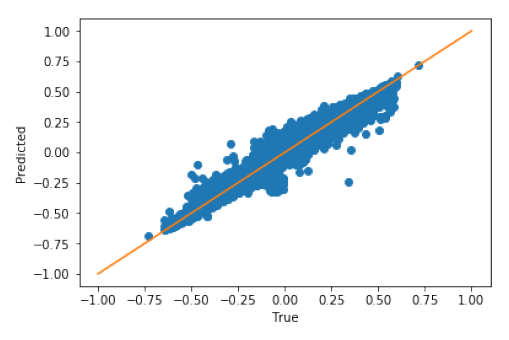

In [10]:
import matplotlib.pyplot as plt
img = plt.imread('results.png')
plt.figure(figsize=(16,6))
plt.imshow(img)
plt.axis('off')

<div id='id-section22'/>

## 2. Predicting J-Couplings

Now based on the obtained charges and the type of J-coupling ('1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN') we will train our ML model.

<div id='id-section221'/>

### 2.1. Load data

Available data includes:

* Dipole moments
* Magnetic Shielding Tensors
* Mulliken Charges (both predicted and given ones)
* Potential Energy
* Scalar Coupling Contributions
* XYZ Coordinates
* Test Set
* Train Set

In [11]:
import pandas as pd
import numpy as np

In [12]:
data_dipole = pd.read_csv('dipole_moments.csv')
data_mag_tens = pd.read_csv('magnetic_shielding_tensors.csv')
data_chg_train = pd.read_csv('mulliken_charges.csv')
data_chg_test = pd.read_csv('mulliken_charges_test_set.csv')
data_PE = pd.read_csv('potential_energy.csv')
data_coupling_contr = pd.read_csv('scalar_coupling_contributions.csv')
data_sub = pd.read_csv('sample_submission.csv')
data_struct = pd.read_csv('structures.csv')
data_test = pd.read_csv('test.csv')
data_train = pd.read_csv('train.csv')

Now let's take a look at each dataset and see how they look like.

### Dipole Moments

In [13]:
data_dipole.head(5)

,molecule_name,X,Y,Z
0,dsgdb9nsd_000001,0.0000,0.0,0.0000
1,dsgdb9nsd_000002,-0.0002,0.0,1.6256
2,dsgdb9nsd_000003,0.0000,0.0,-1.8511
3,dsgdb9nsd_000004,0.0000,0.0,0.0000
4,dsgdb9nsd_000005,0.0000,0.0,-2.8937


In [14]:
data_dipole.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130789 entries, 0 to 130788
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   molecule_name  130789 non-null  object 
 1   X              130789 non-null  float64
 2   Y              130789 non-null  float64
 3   Z              130789 non-null  float64
dtypes: float64(3), object(1)
memory usage: 4.0+ MB


### Magnetic Shielding Tensors

In [15]:
data_mag_tens.head(5)

,molecule_name,atom_index,XX,YX,ZX,XY,YY,ZY,XZ,YZ,ZZ
0,dsgdb9nsd_000001,0,195.3147,0.0000,-0.0001,0.0000,195.3171,0.0007,-0.0001,0.0007,195.3169
1,dsgdb9nsd_000001,1,31.3410,-1.2317,4.0544,-1.2317,28.9546,-1.7173,4.0546,-1.7173,34.0861
2,dsgdb9nsd_000001,2,31.5814,1.2173,-4.1474,1.2173,28.9036,-1.6036,-4.1476,-1.6036,33.8967
3,dsgdb9nsd_000001,3,31.5172,4.1086,1.2723,4.1088,33.9068,1.6950,1.2724,1.6951,28.9579
4,dsgdb9nsd_000001,4,31.4029,-4.0942,-1.1793,-4.0944,34.0776,1.6259,-1.1795,1.6260,28.9013


In [16]:
data_mag_tens.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2358875 entries, 0 to 2358874
Data columns (total 11 columns):
 #   Column         Dtype  
---  ------         -----  
 0   molecule_name  object 
 1   atom_index     int64  
 2   XX             float64
 3   YX             float64
 4   ZX             float64
 5   XY             float64
 6   YY             float64
 7   ZY             float64
 8   XZ             float64
 9   YZ             float64
 10  ZZ             float64
dtypes: float64(9), int64(1), object(1)
memory usage: 198.0+ MB


### Mulliken Charge (train set)

In [17]:
data_chg_train.head(5)

,molecule_name,atom_index,mulliken_charge
0,dsgdb9nsd_000001,0,-0.535689
1,dsgdb9nsd_000001,1,0.133921
2,dsgdb9nsd_000001,2,0.133922
3,dsgdb9nsd_000001,3,0.133923
4,dsgdb9nsd_000001,4,0.133923


In [26]:
data_chg_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2358875 entries, 0 to 2358874
Data columns (total 3 columns):
 #   Column           Dtype  
---  ------           -----  
 0   molecule_name    object 
 1   atom_index       int64  
 2   mulliken_charge  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 54.0+ MB


### Mulliken Charge (test set)

In [27]:
data_chg_test.head(5)

,molecule_name,atom_index,mulliken_charge
0,dsgdb9nsd_000004,0,-0.382772
1,dsgdb9nsd_000004,1,-0.382772
2,dsgdb9nsd_000004,2,0.175373
3,dsgdb9nsd_000004,3,0.175373
4,dsgdb9nsd_000015,0,-0.227002


In [20]:
data_chg_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825120 entries, 0 to 825119
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   molecule_name    825120 non-null  object 
 1   atom_index       825120 non-null  int64  
 2   mulliken_charge  825120 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 18.9+ MB


### Potential Energy

In [21]:
data_PE.head(5)

,molecule_name,potential_energy
0,dsgdb9nsd_000001,-40.523680
1,dsgdb9nsd_000002,-56.560246
2,dsgdb9nsd_000003,-76.426077
3,dsgdb9nsd_000004,-77.335268
4,dsgdb9nsd_000005,-93.428488


In [22]:
data_PE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130789 entries, 0 to 130788
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   molecule_name     130789 non-null  object 
 1   potential_energy  130789 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.0+ MB


### Scaling Coupling Contribution

In [23]:
data_coupling_contr.head(5)

,molecule_name,atom_index_0,atom_index_1,type,fc,sd,pso,dso
0,dsgdb9nsd_000001,1,0,1JHC,83.0224,0.254579,1.25862,0.272010
1,dsgdb9nsd_000001,1,2,2JHH,-11.0347,0.352978,2.85839,-3.433600
2,dsgdb9nsd_000001,1,3,2JHH,-11.0325,0.352944,2.85852,-3.433870
3,dsgdb9nsd_000001,1,4,2JHH,-11.0319,0.352934,2.85855,-3.433930
4,dsgdb9nsd_000001,2,0,1JHC,83.0222,0.254585,1.25861,0.272013


In [24]:
data_coupling_contr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4659076 entries, 0 to 4659075
Data columns (total 8 columns):
 #   Column         Dtype  
---  ------         -----  
 0   molecule_name  object 
 1   atom_index_0   int64  
 2   atom_index_1   int64  
 3   type           object 
 4   fc             float64
 5   sd             float64
 6   pso            float64
 7   dso            float64
dtypes: float64(4), int64(2), object(2)
memory usage: 284.4+ MB


### XYZ Coordinates

In [28]:
data_struct.head(5)

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


In [29]:
data_struct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2358875 entries, 0 to 2358874
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   molecule_name  object 
 1   atom_index     int64  
 2   atom           object 
 3   x              float64
 4   y              float64
 5   z              float64
dtypes: float64(3), int64(1), object(2)
memory usage: 108.0+ MB


### Test Set

In [30]:
data_test.head(5)

,id,molecule_name,atom_index_0,atom_index_1,type
0,4659076,dsgdb9nsd_000004,2,0,2JHC
1,4659077,dsgdb9nsd_000004,2,1,1JHC
2,4659078,dsgdb9nsd_000004,2,3,3JHH
3,4659079,dsgdb9nsd_000004,3,0,1JHC
4,4659080,dsgdb9nsd_000004,3,1,2JHC


In [31]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2505190 entries, 0 to 2505189
Data columns (total 5 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   id             int64 
 1   molecule_name  object
 2   atom_index_0   int64 
 3   atom_index_1   int64 
 4   type           object
dtypes: int64(3), object(2)
memory usage: 95.6+ MB


### Train Set

In [32]:
data_train.head(5)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [33]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4659076 entries, 0 to 4659075
Data columns (total 6 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   id                        int64  
 1   molecule_name             object 
 2   atom_index_0              int64  
 3   atom_index_1              int64  
 4   type                      object 
 5   scalar_coupling_constant  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 213.3+ MB


In order to better understand the types of J-coupling we have, we first print all unique values of column 'type' in our dataset:

In [34]:
data_train['type'].unique()

array(['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN'],
      dtype=object)

In [35]:
data_train['type'].value_counts()

3JHC    1511207
2JHC    1140867
1JHC     709133
3JHH     590529
2JHH     377988
3JHN     166613
2JHN     119059
1JHN      43680
Name: type, dtype: int64

As you can see, we have 8 types of J-coupling which are mostly '3JHC' and '2JHC'. The smallest number corresponds to '1JHN'. This actually shows that our dataset is heavy on Carbohydrate compounds (CH) and there are fewer N-containing structures.

In [36]:
num_atm_per_mol = data_struct['molecule_name'].value_counts()
num_atm_per_mol.sort_index(inplace=True) # sort based on the name of the molecule not num of atoms
print(num_atm_per_mol)

dsgdb9nsd_000001     5
dsgdb9nsd_000002     4
dsgdb9nsd_000003     3
dsgdb9nsd_000004     4
dsgdb9nsd_000005     3
                    ..
dsgdb9nsd_133881    16
dsgdb9nsd_133882    16
dsgdb9nsd_133883    17
dsgdb9nsd_133884    18
dsgdb9nsd_133885    16
Name: molecule_name, Length: 130789, dtype: int64


In [37]:
len(data_train['molecule_name'].unique())

85012

In [38]:
num_atm_per_mol['dsgdb9nsd_000001']

5

<div id='id-section222'/>

### 2.2. Merge charges to our dataset

In [39]:
# merge charge to our train dataset
for atom_idx in range(2):        
    data_train = pd.merge(data_train, data_chg_train, how = 'left',
                          left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                          right_on = ['molecule_name', 'atom_index'])

In [40]:
data_train.head(5)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_index_x,mulliken_charge_x,atom_index_y,mulliken_charge_y
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,1,0.133921,0,-0.535689
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,1,0.133921,2,0.133922
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,1,0.133921,3,0.133923
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,1,0.133921,4,0.133923
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,2,0.133922,0,-0.535689


In [41]:
# merge charge to our test dataset
for atom_idx in range(2):        
    data_test = pd.merge(data_test, data_chg_train, how = 'left',
                         left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                         right_on = ['molecule_name', 'atom_index'])
data_test.head(5)

,id,molecule_name,atom_index_0,atom_index_1,type,atom_index_x,mulliken_charge_x,atom_index_y,mulliken_charge_y
0,4659076,dsgdb9nsd_000004,2,0,2JHC,2,0.20702,0,-0.20702
1,4659077,dsgdb9nsd_000004,2,1,1JHC,2,0.20702,1,-0.20702
2,4659078,dsgdb9nsd_000004,2,3,3JHH,2,0.20702,3,0.20702
3,4659079,dsgdb9nsd_000004,3,0,1JHC,3,0.20702,0,-0.20702
4,4659080,dsgdb9nsd_000004,3,1,2JHC,3,0.20702,1,-0.20702


<div id='id-section223'/>

### 2.3. Data Statistics

In [42]:
data_train.describe()

,id,atom_index_0,atom_index_1,scalar_coupling_constant,atom_index_x,mulliken_charge_x,atom_index_y,mulliken_charge_y
count,4.659076e+06,4.659076e+06,4.659076e+06,4.659076e+06,4.659076e+06,4.659076e+06,4.659076e+06,4.659076e+06
mean,2.329538e+06,1.335677e+01,5.881245e+00,1.591591e+01,1.335677e+01,1.221207e-01,5.881245e+00,-4.141065e-02
std,1.344960e+06,3.269432e+00,4.993794e+00,3.493466e+01,3.269432e+00,4.479061e-02,4.993794e+00,2.403913e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,-4.476050e+01,1.000000e+00,-9.408100e-02,0.000000e+00,-7.334500e-01
25%,1.164769e+06,1.100000e+01,2.000000e+00,-2.551463e-01,1.100000e+01,9.834200e-02,2.000000e+00,-2.367740e-01
50%,2.329538e+06,1.300000e+01,5.000000e+00,2.280350e+00,1.300000e+01,1.134950e-01,5.000000e+00,-4.024200e-02
75%,3.494306e+06,1.600000e+01,8.000000e+00,7.389100e+00,1.600000e+01,1.287710e-01,8.000000e+00,1.185140e-01
max,4.659075e+06,2.800000e+01,2.800000e+01,2.077090e+02,2.800000e+01,4.030940e-01,2.800000e+01,6.358160e-01


In [43]:
data_test.describe()

,id,atom_index_0,atom_index_1,atom_index_x,mulliken_charge_x,atom_index_y,mulliken_charge_y
count,2.505190e+06,2.505190e+06,2.505190e+06,2.505190e+06,2.505190e+06,2.505190e+06,2.505190e+06
mean,5.911670e+06,1.335442e+01,5.882999e+00,1.335442e+01,1.222428e-01,5.882999e+00,-4.096933e-02
std,7.231862e+05,3.269193e+00,4.992456e+00,3.269193e+00,4.504661e-02,4.992456e+00,2.404988e-01
min,4.659076e+06,0.000000e+00,0.000000e+00,0.000000e+00,-1.962000e-02,0.000000e+00,-7.098190e-01
25%,5.285373e+06,1.100000e+01,2.000000e+00,1.100000e+01,9.842925e-02,2.000000e+00,-2.363910e-01
50%,5.911670e+06,1.300000e+01,5.000000e+00,1.300000e+01,1.135080e-01,5.000000e+00,-3.916300e-02
75%,6.537968e+06,1.600000e+01,8.000000e+00,1.600000e+01,1.288440e-01,8.000000e+00,1.187828e-01
max,7.164265e+06,2.800000e+01,2.800000e+01,2.800000e+01,3.923550e-01,2.800000e+01,6.386140e-01


<div id='id-section224'/>

### 2.4. Define Model 1: Random Forest Regressor

In [44]:
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, accuracy_score

Since we have a huge dataset, it is not practical to perform our calculations on regular laptops. Hence, we try to reduce the size of our dataset by choosing a fraction of it and train our model based on that.

In [67]:
data_train.iloc[5036][1]

'dsgdb9nsd_000273'

In [68]:
rdc_list = range(5037,4659076)
data_rdc_size = data_train.drop(rdc_list)
data_rdc_size.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5037 entries, 0 to 5036
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        5037 non-null   int64  
 1   molecule_name             5037 non-null   object 
 2   atom_index_0              5037 non-null   int64  
 3   atom_index_1              5037 non-null   int64  
 4   type                      5037 non-null   object 
 5   scalar_coupling_constant  5037 non-null   float64
 6   atom_index_x              5037 non-null   int64  
 7   mulliken_charge_x         5037 non-null   float64
 8   atom_index_y              5037 non-null   int64  
 9   mulliken_charge_y         5037 non-null   float64
dtypes: float64(3), int64(5), object(2)
memory usage: 432.9+ KB


In [69]:
numerical_cols = ['mulliken_charge_x', 'mulliken_charge_y'] 
categorical_cols = ['type']

numerical_transformer = SimpleImputer(strategy='mean') # the default is mean
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_cols),
                                               ('cat', categorical_transformer, categorical_cols)])

feature_cols = ['mulliken_charge_x', 'mulliken_charge_y', 'type']

X = data_rdc_size[feature_cols]
y = data_rdc_size['scalar_coupling_constant']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

<div id='id-section225'/>

### 2.5. Results of model 1

In [70]:
model_rfr = RandomForestRegressor(n_estimators=100, criterion='mae', random_state=1)
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model_rfr)])
my_pipeline.fit(X_train, y_train)
preds_test = my_pipeline.predict(X_test)
print('MAE:', mean_absolute_error(y_test, preds_test))

MAE: 2.8530273733571434


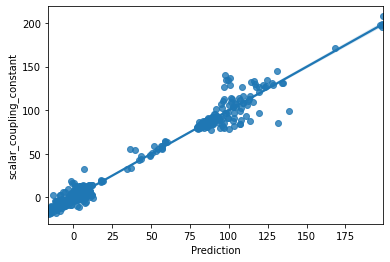

In [102]:
plt.xlabel('Prediction')
plt.ylabel('Actual')
sns.regplot(x=preds_test, y=y_test) # reg line

As it is clear from the figure, the dataset is clustered around several numbers. This is in fact related to the type of J-coupling. Our model predicts the values with small J-coupling fairly well. However, it does fail to give a reasonable results for large J-coulings. One way to overcome this problem is to categorize our data based on the type of J-coupling and model each set individually.

<div id='id-section226'/>

### 2.6. Training with subsets of dataset

In [74]:
data_rdc_size['type'].unique()

array(['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN'],
      dtype=object)

In [75]:
data_rdc_size_1 = data_rdc_size.loc[data_rdc_size['type'] == '1JHC']
data_rdc_size_2 = data_rdc_size.loc[data_rdc_size['type'] == '2JHH']
data_rdc_size_3 = data_rdc_size.loc[data_rdc_size['type'] == '1JHN']
data_rdc_size_4 = data_rdc_size.loc[data_rdc_size['type'] == '2JHN']
data_rdc_size_5 = data_rdc_size.loc[data_rdc_size['type'] == '2JHC']
data_rdc_size_6 = data_rdc_size.loc[data_rdc_size['type'] == '3JHH']
data_rdc_size_7 = data_rdc_size.loc[data_rdc_size['type'] == '3JHC']
data_rdc_size_8 = data_rdc_size.loc[data_rdc_size['type'] == '3JHN']

In [82]:
data_rdc_size_8.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 75 to 4971
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        179 non-null    int64  
 1   molecule_name             179 non-null    object 
 2   atom_index_0              179 non-null    int64  
 3   atom_index_1              179 non-null    int64  
 4   type                      179 non-null    object 
 5   scalar_coupling_constant  179 non-null    float64
 6   atom_index_x              179 non-null    int64  
 7   mulliken_charge_x         179 non-null    float64
 8   atom_index_y              179 non-null    int64  
 9   mulliken_charge_y         179 non-null    float64
dtypes: float64(3), int64(5), object(2)
memory usage: 15.4+ KB


In [83]:
numerical_cols = ['mulliken_charge_x', 'mulliken_charge_y'] 
categorical_cols = ['type']

numerical_transformer = SimpleImputer(strategy='mean') # the default is mean
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_cols),
                                               ('cat', categorical_transformer, categorical_cols)])

feature_cols = ['mulliken_charge_x', 'mulliken_charge_y', 'type']

In [84]:
X1 = data_rdc_size_1[feature_cols]
y1 = data_rdc_size_1['scalar_coupling_constant']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=1)

X2 = data_rdc_size_2[feature_cols]
y2 = data_rdc_size_2['scalar_coupling_constant']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=1)

X3 = data_rdc_size_3[feature_cols]
y3 = data_rdc_size_3['scalar_coupling_constant']
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, random_state=1)

X4 = data_rdc_size_4[feature_cols]
y4 = data_rdc_size_4['scalar_coupling_constant']
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, random_state=1)

X5 = data_rdc_size_5[feature_cols]
y5 = data_rdc_size_5['scalar_coupling_constant']
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, random_state=1)

X6 = data_rdc_size_6[feature_cols]
y6 = data_rdc_size_6['scalar_coupling_constant']
X6_train, X6_test, y6_train, y6_test = train_test_split(X6, y6, random_state=1)

X7 = data_rdc_size_7[feature_cols]
y7 = data_rdc_size_7['scalar_coupling_constant']
X7_train, X7_test, y7_train, y7_test = train_test_split(X7, y7, random_state=1)

X8 = data_rdc_size_8[feature_cols]
y8 = data_rdc_size_8['scalar_coupling_constant']
X8_train, X8_test, y8_train, y8_test = train_test_split(X8, y8, random_state=1)

In [85]:
model_rfr_1 = RandomForestRegressor(n_estimators=100, criterion='mae', random_state=1)
my_pipeline_1 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model_rfr_1)])
my_pipeline_1.fit(X1_train, y1_train)
preds_test_1 = my_pipeline_1.predict(X1_test)
print('MAE1:', mean_absolute_error(y1_test, preds_test_1))

model_rfr_2 = RandomForestRegressor(n_estimators=100, criterion='mae', random_state=1)
my_pipeline_2 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model_rfr_2)])
my_pipeline_2.fit(X2_train, y2_train)
preds_test_2 = my_pipeline_2.predict(X2_test)
print('MAE2:', mean_absolute_error(y2_test, preds_test_2))

model_rfr_3 = RandomForestRegressor(n_estimators=100, criterion='mae', random_state=1)
my_pipeline_3 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model_rfr_3)])
my_pipeline_3.fit(X3_train, y3_train)
preds_test_3 = my_pipeline_3.predict(X3_test)
print('MAE3:', mean_absolute_error(y3_test, preds_test_3))

model_rfr_4 = RandomForestRegressor(n_estimators=100, criterion='mae', random_state=1)
my_pipeline_4 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model_rfr_4)])
my_pipeline_4.fit(X4_train, y4_train)
preds_test_4 = my_pipeline_4.predict(X4_test)
print('MAE4:', mean_absolute_error(y4_test, preds_test_4))

model_rfr_5 = RandomForestRegressor(n_estimators=100, criterion='mae', random_state=1)
my_pipeline_5 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model_rfr_5)])
my_pipeline_5.fit(X5_train, y5_train)
preds_test_5 = my_pipeline_5.predict(X5_test)
print('MAE5:', mean_absolute_error(y5_test, preds_test_5))

model_rfr_6 = RandomForestRegressor(n_estimators=100, criterion='mae', random_state=1)
my_pipeline_6 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model_rfr_6)])
my_pipeline_6.fit(X6_train, y6_train)
preds_test_6 = my_pipeline_6.predict(X6_test)
print('MAE6:', mean_absolute_error(y6_test, preds_test_6))

model_rfr_7 = RandomForestRegressor(n_estimators=100, criterion='mae', random_state=1)
my_pipeline_7 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model_rfr_7)])
my_pipeline_7.fit(X7_train, y7_train)
preds_test_7 = my_pipeline_7.predict(X7_test)
print('MAE7:', mean_absolute_error(y7_test, preds_test_7))

model_rfr_8 = RandomForestRegressor(n_estimators=100, criterion='mae', random_state=1)
my_pipeline_8 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model_rfr_8)])
my_pipeline_8.fit(X8_train, y8_train)
preds_test_8 = my_pipeline_8.predict(X8_test)
print('MAE8:', mean_absolute_error(y8_test, preds_test_8))

MAE1: 6.0789536013215875
MAE2: 2.1380351281456953
MAE3: 3.9093203333333237
MAE4: 2.7940313758750004
MAE5: 1.9870140231292517
MAE6: 3.949017993852458
MAE7: 2.2610812905132454
MAE8: 0.819801095777778


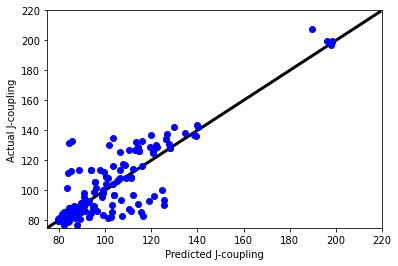

In [187]:
plt.ylabel("Actual J-coupling")
plt.xlabel("Predicted J-coupling") 
plt.ylim(75,220)
plt.xlim(75,220)
xlin = np.arange(75,220)
ylin = np.arange(75,220)
plt.plot(xlin, ylin, color='black',linestyle='-', markersize=6,
         marker='', label='',linewidth=3.0)
plt.plot(preds_test_1, y1_test, color='blue',linestyle='', markersize=6,
         marker='o', label='',linewidth=3.0)

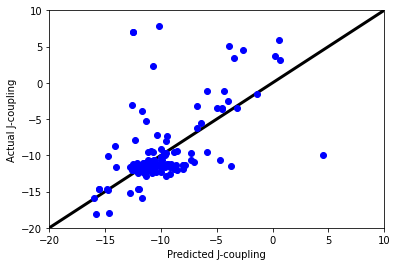

In [186]:
plt.ylabel("Actual J-coupling")
plt.xlabel("Predicted J-coupling") 
plt.ylim(-20,10)
plt.xlim(-20,10)
xlin = np.arange(-20,11)
ylin = np.arange(-20,11)
plt.plot(xlin, ylin, color='black',linestyle='-', markersize=6,
         marker='', label='',linewidth=3.0)
plt.plot(preds_test_2, y2_test, color='blue',linestyle='', markersize=6,
         marker='o', label='',linewidth=3.0)

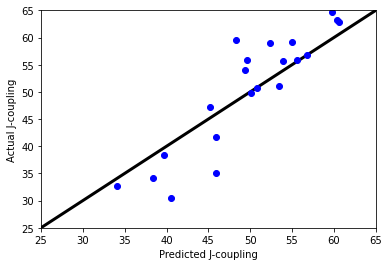

In [185]:
plt.ylabel("Actual J-coupling")
plt.xlabel("Predicted J-coupling") 
plt.ylim(25,65)
plt.xlim(25,65)
xlin = np.arange(25,66)
ylin = np.arange(25,66)
plt.plot(xlin, ylin, color='black',linestyle='-', markersize=6,
         marker='', label='',linewidth=3.0)
plt.plot(preds_test_3, y3_test, color='blue',linestyle='', markersize=6,
         marker='o', label='',linewidth=3.0)

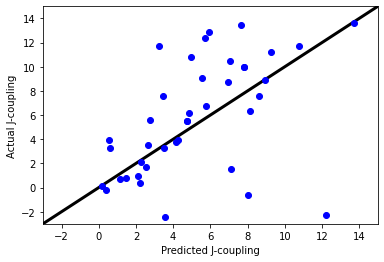

In [184]:
plt.ylabel("Actual J-coupling")
plt.xlabel("Predicted J-coupling") 
plt.ylim(-3,15)
plt.xlim(-3,15)
xlin = np.arange(-3,16)
ylin = np.arange(-3,16)
plt.plot(xlin, ylin, color='black',linestyle='-', markersize=6,
         marker='', label='',linewidth=3.0)
plt.plot(preds_test_4, y4_test, color='blue',linestyle='', markersize=6,
         marker='o', label='',linewidth=3.0)

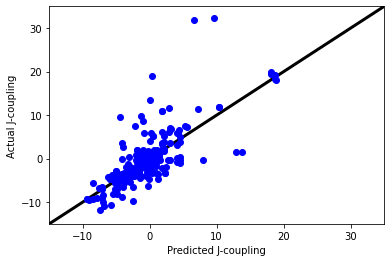

In [183]:
plt.ylabel("Actual J-coupling")
plt.xlabel("Predicted J-coupling") 
plt.ylim(-15,35)
plt.xlim(-15,35)
xlin = np.arange(-15,36)
ylin = np.arange(-15,36)
plt.plot(xlin, ylin, color='black',linestyle='-', markersize=6,
         marker='', label='',linewidth=3.0)
plt.plot(preds_test_5, y5_test, color='blue',linestyle='', markersize=6,
         marker='o', label='',linewidth=3.0)

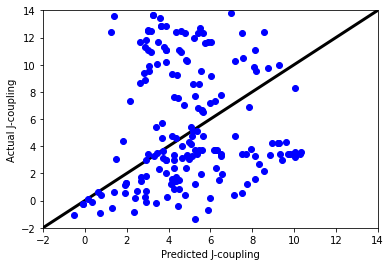

In [182]:
plt.ylabel("Actual J-coupling")
plt.xlabel("Predicted J-coupling") 
plt.ylim(-2,14)
plt.xlim(-2,14)
xlin = np.arange(-2,15)
ylin = np.arange(-2,15)
plt.plot(xlin, ylin, color='black',linestyle='-', markersize=6,
         marker='', label='',linewidth=3.0)
plt.plot(preds_test_6, y6_test, color='blue',linestyle='', markersize=6,
         marker='o', label='',linewidth=3.0)

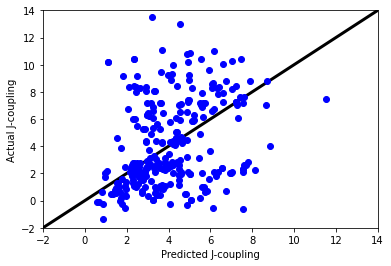

In [179]:
plt.ylabel("Actual J-coupling")
plt.xlabel("Predicted J-coupling") 
plt.ylim(-2,14)
plt.xlim(-2,14)
xlin = np.arange(-2,15)
ylin = np.arange(-2,15)
plt.plot(xlin, ylin, color='black',linestyle='-', markersize=6,
         marker='', label='',linewidth=3.0)
plt.plot(preds_test_7, y7_test, color='blue',linestyle='', markersize=6,
         marker='o', label='',linewidth=3.0)

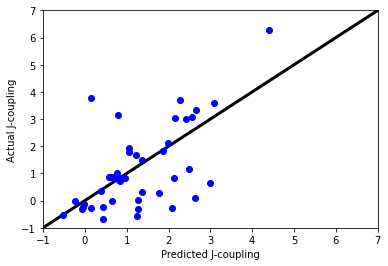

In [178]:
plt.ylabel("Actual J-coupling")
plt.xlabel("Predicted J-coupling") 
plt.ylim(-1,7)
plt.xlim(-1,7)
xlin = np.arange(-1,8)
ylin = np.arange(-1,8)
plt.plot(xlin, ylin, color='black',linestyle='-', markersize=6,
         marker='', label='',linewidth=3.0)
plt.plot(preds_test_8, y8_test, color='blue',linestyle='', markersize=6,
         marker='o', label='',linewidth=3.0)

The weighted average MAE from these 8 different is 3.11 which is slighlty worse than the original MAE = 2.8. It can bee seen that there is no improvement in this case.

<div id='id-section227'/>

### 2.7. Define Model 2: Deep Neural Network

In [141]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.callbacks import EarlyStopping

feature_cols = ['mulliken_charge_x', 'mulliken_charge_y', 'type']
numerical_cols = ['mulliken_charge_x', 'mulliken_charge_y'] 
categorical_cols = ['type']

numerical_transformer = SimpleImputer(strategy='mean') # the default is mean
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_cols),
                                               ('cat', categorical_transformer, categorical_cols)])

X = data_rdc_size[feature_cols]
y = data_rdc_size['scalar_coupling_constant']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

input_shape = [X_train.shape[1]]
print(input_shape)
    
model_dnn = keras.Sequential([layers.Dense(128, activation='relu', input_shape=input_shape),
                              layers.Dense(128, activation='relu'),
                              layers.Dense(128, activation='relu'),
                              layers.Dense(128, activation='relu'),                              
                              layers.Dense(1)])

model_dnn.compile(optimizer="adam", loss="mae")
early_stopping = keras.callbacks.EarlyStopping(patience=10,
                                               min_delta=0.001,
                                               restore_best_weights=True)

[10]


In [142]:
history = model_dnn.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        batch_size=128,
                        callbacks=[early_stopping],
                        epochs=1000)

Epoch 1/1000
30/30 [==============================] - 0s 6ms/step - loss: 21.5176 - val_loss: 18.8630
Epoch 2/1000
30/30 [==============================] - 0s 3ms/step - loss: 14.4913 - val_loss: 5.2564
Epoch 3/1000
30/30 [==============================] - 0s 3ms/step - loss: 5.4599 - val_loss: 4.7922
Epoch 4/1000
30/30 [==============================] - 0s 4ms/step - loss: 5.0065 - val_loss: 4.6355
Epoch 5/1000
30/30 [==============================] - 0s 4ms/step - loss: 4.8086 - val_loss: 4.4273
Epoch 6/1000
30/30 [==============================] - 0s 4ms/step - loss: 4.4773 - val_loss: 4.5328
Epoch 7/1000
30/30 [==============================] - 0s 3ms/step - loss: 4.6416 - val_loss: 4.3773
Epoch 8/1000
30/30 [==============================] - 0s 3ms/step - loss: 4.5615 - val_loss: 4.3341
Epoch 9/1000
30/30 [==============================] - 0s 3ms/step - loss: 4.3802 - val_loss: 4.2666
Epoch 10/1000
30/30 [==============================] - 0s 4ms/step - loss: 4.3342 - val_loss: 4.2

30/30 [==============================] - 0s 3ms/step - loss: 3.9944 - val_loss: 3.9532
Epoch 83/1000
30/30 [==============================] - 0s 3ms/step - loss: 3.7641 - val_loss: 3.9702
Epoch 84/1000
30/30 [==============================] - 0s 3ms/step - loss: 4.0498 - val_loss: 3.9847
Epoch 85/1000
30/30 [==============================] - 0s 3ms/step - loss: 3.8882 - val_loss: 4.1805
Epoch 86/1000
30/30 [==============================] - 0s 3ms/step - loss: 3.9584 - val_loss: 4.0154


In [143]:
preds_test = model_dnn.predict(X_test)
print('MAE:', mean_absolute_error(y_test, preds_test))

MAE: 3.9277684988618096


         loss   val_loss
0   21.149635  18.863014
1   10.740640   5.256446
2    5.300310   4.792208
3    4.875573   4.635539
4    4.803689   4.427287
..        ...        ...
81   3.929301   3.953207
82   3.912185   3.970232
83   4.011397   3.984737
84   3.947507   4.180469
85   3.956093   4.015368

[86 rows x 2 columns]
Best Validation Loss: 3.9277684688568115


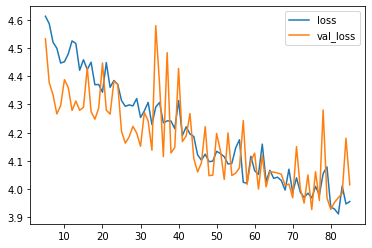

In [152]:
history_df = pd.DataFrame(history.history)
print(history_df)
# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()

print('Best Validation Loss:', (history_df['val_loss'].min()))

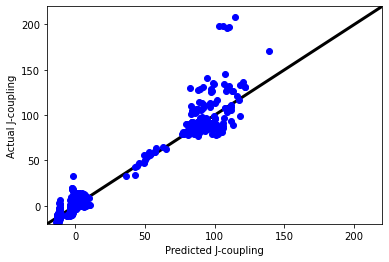

In [175]:
plt.ylabel("Actual J-coupling")
plt.xlabel("Predicted J-coupling") 
plt.ylim(-20,220)
plt.xlim(-20,220)
xlin = np.arange(-20,220)
ylin = np.arange(-20,220)
plt.plot(xlin, ylin, color='black',linestyle='-', markersize=6,
         marker='', label='',linewidth=3.0)
plt.plot(preds_test, y_test, color='blue',linestyle='', markersize=6,
         marker='o', label='',linewidth=3.0)

<div id='id-section23'/>

## 3. Summary
In summary, we first predicted the mulliken charges using Atom-Centered Symmetry Functions (ACSFs). Then we used 2 different models, Random Forest Regressor (RFR) and Deep Neural Network (DNN), to predict the J-coupling constants between pairs of atoms. The obtained MAE for RFR was 2.8 and for DNN was 3.9 showing that RFR performed better. Note that due to the huge amount of data, we only used a tiny fraction of the available data to make the calculations feasible on a regular laptop. By using more data one can get much lower MAEs.